In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch , torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import optuna
import os
import glob
import pywt
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('You are using :',device)

You are using : cuda


Data transformation

In [2]:
#------------------------------------
# Function for Wavelet Decomposition
#------------------------------------

def wavelet_decomposition(image, mean=None, std=None):
    image = np.array(image)/255.0
    channels = [image[..., i] for i in range(3)]
    LLs, LHs, HLs, HHs = [], [], [], []
    
    for ch in channels:
        coeffs2 = pywt.swt2(ch, 'db1', level=1)
        LL, (LH, HL, HH) = coeffs2[0]
        LLs.append(LL); LHs.append(LH); HLs.append(HL); HHs.append(HH)
    
    Image_rgb = (image - mean)/std
    LL_rgb = (np.stack(LLs, axis=-1)-mean)/std
    LH_rgb = (np.stack(LHs, axis=-1)-mean)/std
    HL_rgb = (np.stack(HLs, axis=-1)-mean)/std
    HH_rgb = (np.stack(HHs, axis=-1)-mean)/std

    Image_concat = np.concatenate([Image_rgb, LL_rgb, LH_rgb, HL_rgb, HH_rgb], axis=2)
    Image_tensor = torch.from_numpy(Image_concat).float().permute(2, 0, 1)
    return Image_tensor

In [3]:
#--------------------------------------
# Class to load the images into Dataset
#--------------------------------------

class Load_Dataset(Dataset):
    def __init__(self, data_path, transform = None):
        self.data_path = data_path
        self.transform = transform
        self.classes = sorted(os.listdir(self.data_path))
        self.samples = []
        self.targets = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for idx, cls in enumerate(self.classes):
            for path in glob.glob(os.path.join(self.data_path, cls) + '/*'):
                self.samples.append(path)
                self.targets.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path = self.samples[idx]
        target = self.targets[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return (image, torch.tensor(target, dtype=torch.long))

In [4]:
#------------------------------------------------
# Class for decomposing the images of the dataset
#------------------------------------------------

class Transform_Dataset(Dataset):
    def __init__(self, data_images, mean = None, std= None):  
        if mean is None or std is None:
            raise ValueError("Provide the mean and std")
        self.data_images = data_images
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, idx):
        image = self.data_images[idx][0]
        target = self.data_images[idx][1]
        image = image.resize((150,150))
        image_tensor = wavelet_decomposition(image, self.mean, self.std)
        return (image_tensor, target)

Model Design

In [5]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        if stride>1:
            padding= kernel_size//stride
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding, groups=in_channels)
        
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [6]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel):
        super(InvertedResidualBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            Conv(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            Conv(in_channels=hidden_channels,out_channels=hidden_channels, kernel_size=kernel, padding='same'),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            Conv(in_channels=hidden_channels, out_channels=in_channels, kernel_size=1))

    def forward(self, x):
        out = x + self.convolution(x)
        return out

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel):
        super(ResidualBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            Conv(in_channels=channels, out_channels=1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            Conv(in_channels=1,out_channels=1, kernel_size=kernel, padding='same'),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            Conv(in_channels=1, out_channels=channels, kernel_size=1))

    def forward(self, x):
        out = x + self.convolution(x)
        return out

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Block, self).__init__()
        self.str=stride
        self.conv = Conv(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchNorm = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(2,2)

    def forward(self, x):
        out = F.leaky_relu(self.batchNorm(self.conv(x)), negative_slope=0.01)
        if self.str == 1:
            out = self.maxpool(out)
        return out

In [9]:
#--------------------------
# Class of the custom model
#--------------------------

class EMU_FireNet(nn.Module):
    def __init__(self, depth1, depth2, depth3, depth4, depth5, depth6,
                 depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                 kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize, droupout=0.2):
        super(EMU_FireNet, self).__init__()
        
        self.branch1 = Block(3, depth1, kernel1, stride = stride, padding = padding1)
        self.branch2 = Block(3, depth2, kernel1, stride = stride, padding = padding1)
        #self.branch3 = Block(9, depth3, kernel1, stride = stride, padding = padding1)

        self.features = nn.Sequential(
            Conv(depth1+depth2+depth3, depth4, kernel2, padding=padding2),
            nn.BatchNorm2d(depth4),
            nn.ReLU(),
            Conv(depth4, depth5, kernel2, stride=1),
            ResidualBlock(depth5, kernel2),
            nn.BatchNorm2d(depth5),
            nn.ReLU(),
            # nn.MaxPool2d(2,2),
            Conv(depth5, depth6, kernel3,stride=2),
            InvertedResidualBlock(depth6, hidden_depth, kernel3),
            nn.BatchNorm2d(depth6),
            nn.ReLU(),
            Conv(depth6, depth7, kernel3, padding=padding2),
            ResidualBlock(depth7, kernel3),
            nn.BatchNorm2d(depth7),
            nn.ReLU(),
            Conv(depth7, depth8, kernel3, stride=2),
            ResidualBlock(depth8, kernel3),
            nn.BatchNorm2d(depth8),
            nn.ReLU(),
            # nn.MaxPool2d(2,2),
            Conv(depth8, depth8, kernel3, padding= padding2),
            nn.BatchNorm2d(depth8),
            nn.ReLU(),
            Conv(depth8, depth9, kernel3, stride=2),
            InvertedResidualBlock(depth9, hidden_depth2, kernel3),
            nn.BatchNorm2d(depth9),
            nn.ReLU(),
            Conv(depth9, depth10, kernel2, stride=2),
            nn.BatchNorm2d(depth10),
            nn.ReLU(),
        )
        self.averagepool = nn.AvgPool2d(2,2)
        self.adaptivepooling = nn.AdaptiveAvgPool2d((avgsize,avgsize))
        self.classifier = nn.Sequential(
            nn.Dropout(p=droupout),
            nn.Linear(avgsize*avgsize*depth10, 2),
            # nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        out_1 = self.branch1(x[:,:3,:,:])
        out_2 = self.branch2(x[:,3:6,:,:])
        out_3 = self.averagepool(x[:,6:,:,:])
        
        out = torch.cat([out_1, out_2, out_3], dim=1)
        out = self.features(out)
        out = self.adaptivepooling(out)
        out = out.view(x.size(0),-1)
        out = self.classifier(out)
        return out

Fine tune the hyperparameters using BO 


In [16]:

#---------------------------------------
# Define objective function using optuna
#---------------------------------------

def objective(trial):
    # define the search space
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-2, log=True)
    # opt= trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    depth1 = trial.suggest_categorical("depth1", [8, 16,32,64 ])
    depth2 = trial.suggest_categorical("depth2", [1, 2 ])
    depth3 = 9
    depth4 = trial.suggest_categorical("depth4", [16, 32, 64])
    depth5 = trial.suggest_categorical("depth5", [24, 32, 64])
    depth6 = trial.suggest_categorical("depth6", [32, 64, 128])
    depth7 = trial.suggest_categorical("depth7", [64, 128, 256])
    depth8 = trial.suggest_categorical("depth8", [128, 224, 512])
    depth9 = trial.suggest_categorical("depth9", [224, 256, 512])
    depth10 = trial.suggest_categorical("depth10", [256, 512])
    kernel1 = trial.suggest_categorical("kernel1", [5, 7, 11])
    kernel2 = trial.suggest_categorical("kernel2", [3, 5])
    kernel3 = 3
    avgsize = 1
    dropout = 0.2 
    hidden_depth = 128
    hidden_depth2 = 512
    stride = 2
    padding1 = 5
    padding2 = 0
    
    # data Loader
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)
    
    # model initiliaztion
    model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize,dropout)
    model.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    # optimizer ssearchh space
    # if opt == 'Adam':
    #     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
    # elif opt == 'SGD':
    #     optimizer = optim.SGD(model.parameters(), lr= learning_rate, momentum=0.9, weight_decay=0.0005)
    # else:
    #     optimizer = optim.RMSprop(model.parameters(), lr= learning_rate, weight_decay=0.0005)
    
    optimizer = optim.Adam(model.parameters(),lr= learning_rate, weight_decay= 0.00045)
    
    
    # Model train
    model.train()
    for epoch in range(5):      # 10 is the upper limit of epochs
        for inputs, targets in tqdm(train_loader, desc=f'Trainin Loop {epoch+1}', leave= False):
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # model evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total

    return accuracy

In [17]:
study_model = optuna.create_study(direction = 'maximize', sampler= optuna.samplers.GPSampler())
study_model.optimize(objective, n_trials= 15)



C:\Users\Sc\AppData\Local\Temp\ipykernel_6768\1131860725.py:1: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_model = optuna.create_study(direction = 'maximize', sampler= optuna.samplers.GPSampler())
[I 2025-11-13 08:22:14,529] A new study created in memory with name: no-name-d0770af1-c39f-479d-a177-0545a2e5c1ba
[I 2025-11-13 09:08:13,844] Trial 0 finished with value: 0.520619731146047 and parameters: {'batch_size': 128, 'learning_rate': 4.793979231294992e-07, 'depth1': 32, 'depth2': 2, 'depth4': 32, 'depth5': 24, 'depth6': 64, 'depth7': 256, 'depth8': 128, 'depth9': 256, 'depth10': 256, 'kernel1': 11, 'kernel2': 3}. Best is trial 0 with value: 0.520619731146047.
[I 2025-11-13 09:54:57,070] Trial 1 finished with value: 0.949419002050581 and parameters: {'batch_size': 256, 'learning_rate': 0.0029153714239884636, 'depth1': 32, 'depth2': 1, 'depth4': 16, 'depth5': 64, 'depth6': 128, 'depth7': 256, 'depth8': 224, 'dep

In [18]:
print('Best hyperparameters :', study_model.best_params)

Best hyperparameters : {'batch_size': 32, 'learning_rate': 0.0004364761238612481, 'depth1': 8, 'depth2': 2, 'depth4': 64, 'depth5': 24, 'depth6': 64, 'depth7': 64, 'depth8': 512, 'depth9': 256, 'depth10': 256, 'kernel1': 5, 'kernel2': 5}


In [10]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2

model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize,dropout).to(device)

summary(model, input_size=(15,150,150))

# x = torch.randn(10, 15, 250, 250).to(device)

# model.to(device)

# out = model(x)

# print(out.shape)
# out

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 75, 75]             150
            Conv2d-2           [-1, 32, 75, 75]             128
              Conv-3           [-1, 32, 75, 75]               0
       BatchNorm2d-4           [-1, 32, 75, 75]              64
             Block-5           [-1, 32, 75, 75]               0
            Conv2d-6            [-1, 3, 75, 75]             150
            Conv2d-7            [-1, 1, 75, 75]               4
              Conv-8            [-1, 1, 75, 75]               0
       BatchNorm2d-9            [-1, 1, 75, 75]               2
            Block-10            [-1, 1, 75, 75]               0
        AvgPool2d-11            [-1, 9, 75, 75]               0
           Conv2d-12           [-1, 42, 73, 73]             420
           Conv2d-13           [-1, 64, 73, 73]           2,752
             Conv-14           [-1, 64,

Data Collection and Preprocessing

In [11]:
#-------------------------------------
# Load the data and apply random split
#-------------------------------------

# train_path = r'../Dataset/Fire, Smoke and Non-Fire (binary)/train/'
train_path = r'./train2/'
mean = [0.4029, 0.3436, 0.2767]
std = [0.2259, 0.1956, 0.1756]
transform = transforms.Compose([
            transforms.Resize((250,250)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

dataset = Load_Dataset(train_path)

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

print(dataset.class_to_idx)
print(f'Size of the training data : {len(train_data)}') 
print(f'Size of the validation data : {len(val_data)}')

{'fire': 0, 'non fire': 1}
Size of the training data : 17555
Size of the validation data : 4389


In [ ]:
# ------------------------------------
# Function to calculate  mean and std
# ------------------------------------

def compute_mean_and_std(dataset):
    mean = 0.0
    std = 0.0
    nb_samples = 0

    to_tensor = transforms.ToTensor()
    for image,_ in tqdm(dataset):
        data = to_tensor(image).to(device)
        mean += data.mean(dim=(1,2))
        std += data.std(dim=(1,2))
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples

    clear_output()
    print(f"Mean: {mean.cpu()}")
    print(f"Std: {std.cpu()}")

# compute_mean_and_std(train_data)

In [12]:
#--------------------------------------
# Transform the train data and val data
#--------------------------------------

mean = [0.4029, 0.3436, 0.2767]
std = [0.2259, 0.1956, 0.1756]

train_dataset = Transform_Dataset(train_data, mean, std)
val_dataset = Transform_Dataset(val_data, mean, std)

print("Data is transformed into tensor")
print(next(iter(train_dataset))[0].shape)

Data is transformed into tensor
torch.Size([15, 150, 150])


Training Model Configuration

In [13]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2

model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize)
                       

batch_size = 32
learning_rate =  0.0011964


model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00045)
loss_function = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, 11, 0.1)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size)

In [14]:
#----------------------------------------------
# Training the model with tuned hyperparameters
#----------------------------------------------

num_epochs=25

best_train_loss = float('inf')
best_val_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy =0.0
    
    for images,labels in tqdm(train_loader,leave=None):
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prediction = torch.argmax(outputs,dim =1)            
        train_accuracy += torch.sum(prediction == labels.data)
    
    scheduler.step()
            
    # Evaluation of the model 
    model.eval()
    val_loss = 0.0
    val_accuracy =0.0

    for images,labels in val_loader:
        images,labels = images.to(device),labels.to(device)
        with torch.no_grad():
            
            outputs = model(images)
            loss = loss_function(outputs,labels)
            val_loss += loss.item()
            prediction = torch.argmax(outputs,dim =1)
            val_accuracy += torch.sum(prediction == labels.data)
            
    print(f"Epoch {epoch +1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {100*(train_accuracy/len(train_data)):.4f},\
           Val Loss: {val_loss/len(val_loader):.4f},  Val Accuracy: {100*(val_accuracy/len(val_data)):.4f}")
    
    if best_train_loss > train_loss and best_val_accuracy < val_accuracy:
        best_train_loss = train_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch+1
        torch.save(model.state_dict(),'EMU_FireNet_BO_BestWeighs_PV6.pth')

print(f'The best performance epoch : {best_epoch}, train loss {best_train_loss/len(train_loader):.4f},\
      and val acc {100*best_val_accuracy/len(val_data):.4f}')

100%|██████████| 548/548 [08:35<00:00,  1.06it/s]


Epoch 1/25, Train Loss: 0.2294, Train Accuracy: 91.1478,           Val Loss: 0.1353,  Val Accuracy: 96.1722


100%|██████████| 548/548 [10:02<00:00,  1.10s/it]


Epoch 2/25, Train Loss: 0.1296, Train Accuracy: 95.5967,           Val Loss: 0.1051,  Val Accuracy: 96.3773


100%|██████████| 548/548 [09:58<00:00,  1.09s/it]


Epoch 3/25, Train Loss: 0.1046, Train Accuracy: 96.3600,           Val Loss: 0.0860,  Val Accuracy: 97.6077


100%|██████████| 548/548 [10:02<00:00,  1.10s/it]


Epoch 4/25, Train Loss: 0.0854, Train Accuracy: 96.9524,           Val Loss: 0.1161,  Val Accuracy: 95.8533


100%|██████████| 548/548 [09:54<00:00,  1.08s/it]


Epoch 5/25, Train Loss: 0.0767, Train Accuracy: 97.3569,           Val Loss: 0.1198,  Val Accuracy: 96.2406


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 6/25, Train Loss: 0.0742, Train Accuracy: 97.4025,           Val Loss: 0.0673,  Val Accuracy: 98.1317


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 7/25, Train Loss: 0.0714, Train Accuracy: 97.5904,           Val Loss: 0.0841,  Val Accuracy: 97.2887


100%|██████████| 548/548 [09:46<00:00,  1.07s/it]


Epoch 8/25, Train Loss: 0.0605, Train Accuracy: 97.8923,           Val Loss: 0.0973,  Val Accuracy: 96.7646


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 9/25, Train Loss: 0.0618, Train Accuracy: 97.9037,           Val Loss: 0.0617,  Val Accuracy: 98.2456


100%|██████████| 548/548 [08:50<00:00,  1.03it/s]


Epoch 10/25, Train Loss: 0.0580, Train Accuracy: 97.9664,           Val Loss: 0.0602,  Val Accuracy: 98.2912


100%|██████████| 548/548 [10:04<00:00,  1.10s/it]


Epoch 11/25, Train Loss: 0.0539, Train Accuracy: 98.1999,           Val Loss: 0.0592,  Val Accuracy: 98.1545


100%|██████████| 548/548 [10:04<00:00,  1.10s/it]


Epoch 12/25, Train Loss: 0.0336, Train Accuracy: 98.9120,           Val Loss: 0.0495,  Val Accuracy: 98.5418


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 13/25, Train Loss: 0.0247, Train Accuracy: 99.1911,           Val Loss: 0.0491,  Val Accuracy: 98.6557


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 14/25, Train Loss: 0.0215, Train Accuracy: 99.2652,           Val Loss: 0.0510,  Val Accuracy: 98.6785


100%|██████████| 548/548 [10:02<00:00,  1.10s/it]


Epoch 15/25, Train Loss: 0.0159, Train Accuracy: 99.4816,           Val Loss: 0.0503,  Val Accuracy: 98.7241


100%|██████████| 548/548 [10:04<00:00,  1.10s/it]


Epoch 16/25, Train Loss: 0.0149, Train Accuracy: 99.5044,           Val Loss: 0.0520,  Val Accuracy: 98.7241


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 17/25, Train Loss: 0.0111, Train Accuracy: 99.6069,           Val Loss: 0.0524,  Val Accuracy: 98.6102


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 18/25, Train Loss: 0.0108, Train Accuracy: 99.6525,           Val Loss: 0.0591,  Val Accuracy: 98.6329


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 19/25, Train Loss: 0.0090, Train Accuracy: 99.6981,           Val Loss: 0.0565,  Val Accuracy: 98.7697


100%|██████████| 548/548 [10:02<00:00,  1.10s/it]


Epoch 20/25, Train Loss: 0.0066, Train Accuracy: 99.7494,           Val Loss: 0.0609,  Val Accuracy: 98.7924


100%|██████████| 548/548 [10:04<00:00,  1.10s/it]


Epoch 21/25, Train Loss: 0.0066, Train Accuracy: 99.7380,           Val Loss: 0.0560,  Val Accuracy: 98.7013


100%|██████████| 548/548 [10:06<00:00,  1.11s/it]


Epoch 22/25, Train Loss: 0.0065, Train Accuracy: 99.7266,           Val Loss: 0.0582,  Val Accuracy: 98.7241


100%|██████████| 548/548 [10:04<00:00,  1.10s/it]


Epoch 23/25, Train Loss: 0.0054, Train Accuracy: 99.7778,           Val Loss: 0.0598,  Val Accuracy: 98.7241


100%|██████████| 548/548 [10:03<00:00,  1.10s/it]


Epoch 24/25, Train Loss: 0.0041, Train Accuracy: 99.8462,           Val Loss: 0.0585,  Val Accuracy: 98.7469


100%|██████████| 548/548 [10:06<00:00,  1.11s/it]


Epoch 25/25, Train Loss: 0.0054, Train Accuracy: 99.7778,           Val Loss: 0.0581,  Val Accuracy: 98.6557
The best performance epoch : 20, train loss 0.0066,      and val acc 98.7924


Testing model Configuration with Large Kaggle 

In [15]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2

model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize)

model.load_state_dict(torch.load('EMU_FireNet_BO_BestWeighs_PV6.pth'))

<All keys matched successfully>

In [16]:
def model_predict(test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    predictions = []
    targets = []
    count = 0

    for images,labels in tqdm(test_loader):
        images,labels = images.to(device),labels.to(device)
        with torch.no_grad():

            outputs = model(images)
            loss = loss_function(outputs,labels)
            test_loss += loss.item()
            prediction = torch.argmax(outputs,dim =1) 
            test_accuracy += torch.sum(prediction == labels.data)
            predictions.extend(prediction.cpu())
            targets.extend(labels.cpu())
            count += images.size(0)
            
    cm = confusion_matrix(targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'Blues', cbar= False, yticklabels=['fire', 'non fire'],\
                xticklabels=['fire', 'non fire'],square=True, center = True)
    print(f" test Loss: {test_loss/len(test_loader):.4f},  test Accuracy: {100*(test_accuracy/count):.4f}")
    plt.show()

In [17]:
mean = [0.4029, 0.3436, 0.2767]
std = [0.2259, 0.1956, 0.1756]

test_path = r'./test/'
test_data = Load_Dataset(test_path)
test_dataset = Transform_Dataset(test_data, mean, std)

print(test_data.class_to_idx)
print(f'Size of the test data : {len(test_data)}')

{'fire': 0, 'non fire': 1}
Size of the test data : 7000


100%|██████████| 438/438 [02:52<00:00,  2.54it/s]


 test Loss: 0.0251,  test Accuracy: 99.4143


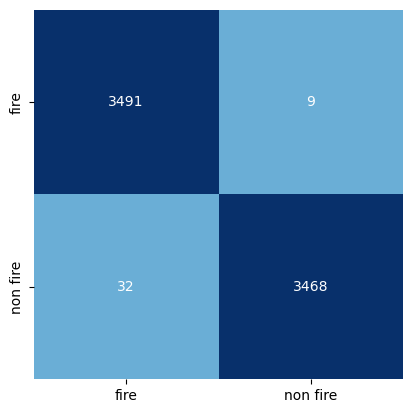

In [18]:
test_loader = DataLoader(test_dataset, 16, None)
model.to(device)
model_predict(test_loader)

Test with corsican dataset 1-class

In [19]:
mean = [0.4009, 0.3412, 0.2750]
std = [0.2247, 0.1942, 0.1743]

corsican_path = r'c:/Users/Sc/Desktop/CorsicanDataset/'
corsican_data = Load_Dataset(corsican_path)
corsican_dataset = Transform_Dataset(corsican_data, mean, std)

print(corsican_data.class_to_idx)
print(f'Size of the test data : {len(corsican_data)}')

{'fire': 0}
Size of the test data : 500


In [20]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2

model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize)
                       
model.load_state_dict(torch.load('EMU_FireNet_BO_BestWeighs_PV6.pth'))



<All keys matched successfully>

In [21]:
def model_predict(test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    predictions = []
    targets = []
    count = 0

    for images,labels in tqdm(test_loader):
        images,labels = images.to(device),labels.to(device)
        with torch.no_grad():

            outputs = model(images)
            loss = loss_function(outputs,labels)
            test_loss += loss.item()
            prediction = torch.argmax(outputs,dim =1) 
            test_accuracy += torch.sum(prediction == labels.data)
            predictions.extend(prediction.cpu())
            targets.extend(labels.cpu())
            count += images.size(0)
            
    cm = confusion_matrix(targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'Blues', cbar= False, yticklabels=['fire', 'non fire'],\
                xticklabels=['fire', 'non fire'],square=True, center = True)
    print(f" test Loss: {test_loss/len(test_loader):.4f},  test Accuracy: {100*(test_accuracy/count):.4f}")
    plt.show()

100%|██████████| 16/16 [00:52<00:00,  3.29s/it]

 test Loss: 0.1444,  test Accuracy: 94.6000


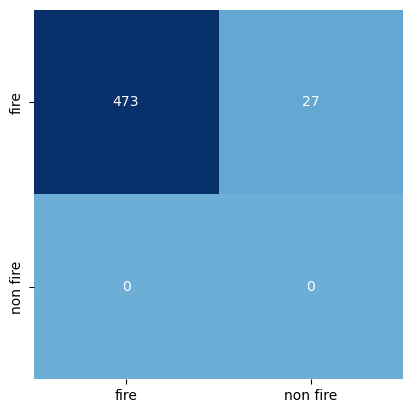

In [22]:
corsicandata_loader = DataLoader(corsican_dataset, 32, None)
model.to(device)

model_predict(corsicandata_loader)

Test using DeepFire Dataset


In [23]:
#---------------------------------------------
# Import the data, preprocess and random split
#---------------------------------------------
mean = [0.4009, 0.3412, 0.2750]
std = [0.2247, 0.1942, 0.1743]

deepfire_path = r'c:/Users/Sc/Desktop/Programs_VisualStudioCode/Dataset2/'
deepfire_data = Load_Dataset(deepfire_path)
deepfire_dataset = Transform_Dataset(deepfire_data, mean, std)

print(deepfire_data.class_to_idx)
print(f'Size of the test data : {len(deepfire_data)}')

{'F': 0, 'N': 1}
Size of the test data : 1900


In [24]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2


model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize)
                       
model.load_state_dict(torch.load('EMU_FireNet_BO_BestWeighs_PV6.pth'))





<All keys matched successfully>

In [25]:
def model_predict(test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    predictions = []
    targets = []
    count = 0

    for images,labels in tqdm(test_loader):
        images,labels = images.to(device),labels.to(device)
        with torch.no_grad():

            outputs = model(images)
            loss = loss_function(outputs,labels)
            test_loss += loss.item()
            prediction = torch.argmax(outputs,dim =1) 
            test_accuracy += torch.sum(prediction == labels.data)
            predictions.extend(prediction.cpu())
            targets.extend(labels.cpu())
            count += images.size(0)
            
    cm = confusion_matrix(targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'Blues', cbar= False, yticklabels=['fire', 'non fire'],\
                xticklabels=['fire', 'non fire'],square=True, center = True)
    print(f" test Loss: {test_loss/len(test_loader):.4f},  test Accuracy: {100*(test_accuracy/count):.4f}")
    plt.show()

100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


 test Loss: 0.0038,  test Accuracy: 99.9474


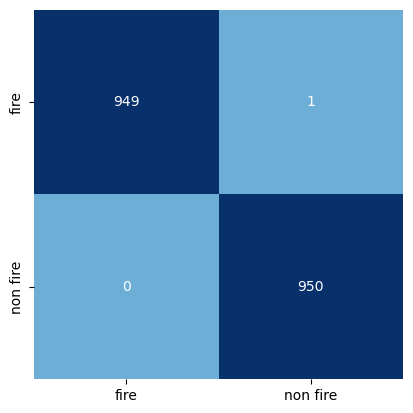

In [26]:
batch_size = 32
deepfire_loader = DataLoader(deepfire_dataset, batch_size, None)
model.to(device)

model_predict(deepfire_loader)

Test using EMUDataset

In [27]:
#---------------------------------------------
# Import the data, preprocess and random split
#---------------------------------------------
mean = [0.4009, 0.3412, 0.2750]
std = [0.2247, 0.1942, 0.1743]

emudataset_path = r'c:/Users/Sc/Desktop/EMUDataset/'
emu_data = Load_Dataset(emudataset_path)
emu_dataset = Transform_Dataset(emu_data, mean, std)

print(emu_data.class_to_idx)
print(f'Size of the test data : {len(emu_data)}')

{'F': 0, 'N': 1}
Size of the test data : 3606


In [28]:
depth1 = 32
depth2 = 1
depth3 = 9
depth4 = 64
depth5 = 64
depth6 = 128
depth7 = 64
depth8 = 224
depth9 = 512
depth10 = 512
hidden_depth = 128
hidden_depth2 = 512
kernel1 = 7
kernel2 = 3
kernel3 = 3
stride = 2
padding1 = 5
padding2 = 0
avgsize = 1
dropout = 0.2

model = EMU_FireNet(depth1, depth2, depth3, depth4, depth5, depth6,
                    depth7, depth8, depth9, depth10, hidden_depth, hidden_depth2,
                    kernel1, kernel2, kernel3, stride, padding1, padding2, avgsize)
                       
model.load_state_dict(torch.load('EMU_FireNet_BO_BestWeighs_PV6.pth'))


<All keys matched successfully>

In [29]:
def model_predict(test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    predictions = []
    targets = []
    count = 0

    for images,labels in tqdm(test_loader):
        images,labels = images.to(device),labels.to(device)
        with torch.no_grad():

            outputs = model(images)
            loss = loss_function(outputs,labels)
            test_loss += loss.item()
            prediction = torch.argmax(outputs,dim =1) 
            test_accuracy += torch.sum(prediction == labels.data)
            predictions.extend(prediction.cpu())
            targets.extend(labels.cpu())
            count += images.size(0)
            
    cm = confusion_matrix(targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'Blues', cbar= False, yticklabels=['fire', 'non fire'],\
                xticklabels=['fire', 'non fire'],square=True, center = True)
    print(f" test Loss: {test_loss/len(test_loader):.4f},  test Accuracy: {100*(test_accuracy/count):.4f}")
    plt.show()

100%|██████████| 113/113 [09:17<00:00,  4.93s/it]

 test Loss: 0.1348,  test Accuracy: 96.8663


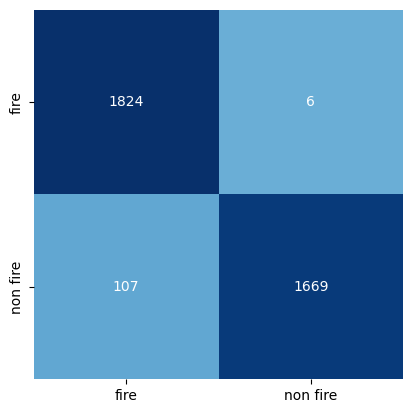

In [30]:
batch_size = 32
emudata_loader = DataLoader(emu_dataset, batch_size, None)
model.to(device)

model_predict(emudata_loader)

In [35]:
summary(model, input_size=(15,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 75, 75]             150
            Conv2d-2           [-1, 16, 75, 75]              64
              Conv-3           [-1, 16, 75, 75]               0
       BatchNorm2d-4           [-1, 16, 75, 75]              32
             Block-5           [-1, 16, 75, 75]               0
            Conv2d-6            [-1, 3, 75, 75]             150
            Conv2d-7            [-1, 2, 75, 75]               8
              Conv-8            [-1, 2, 75, 75]               0
       BatchNorm2d-9            [-1, 2, 75, 75]               4
            Block-10            [-1, 2, 75, 75]               0
        AvgPool2d-11            [-1, 9, 75, 75]               0
           Conv2d-12           [-1, 27, 71, 71]             702
           Conv2d-13           [-1, 64, 71, 71]           1,792
             Conv-14           [-1, 64,